In [1]:
import sys
sys.path.append('/Users/koush/Projects/Banksy_py')


In [2]:
from banksy_utils.load_data import load_adata, display_adata

In [3]:
load_adata

<function banksy_utils.load_data.load_adata(filepath: str, load_adata_directly: bool, adata_filename: str, gcm_filename: str = '', locations_filename: str = '', coord_keys: Tuple[str] = ('xcoord', 'ycoord', 'xy_coord')) -> anndata._core.anndata.AnnData>

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

r = 100  # predefined radius in micrometers
epsilon = 0.001  # trivial value
sigma_max = 53.8

def calculate_sigma(r, epsilon):
    return r / np.sqrt(-2 * np.log(epsilon))

def gaussian_kernel(distances, sigma):
    return np.exp(-np.square(distances) / (2 * sigma**2)) / (sigma * np.sqrt(2 * np.pi))

def calculate_lr_scores(x, y, X, sigma):
    coords = np.column_stack((x, y))
    distances = cdist(coords, coords)
    weights = gaussian_kernel(distances, sigma)
    
    # Create a mask to exclude self-interactions
    mask = np.eye(len(x), dtype=bool)
    weights[mask] = 0
    
    # Normalize weights to sum to 1 for each point
    row_sums = weights.sum(axis=1)
    weights = weights / row_sums[:, np.newaxis]
    
    return np.dot(weights, X)

In [47]:
import scanpy as sc
adata = sc.read_h5ad('./.cache/adata_train.h5ad')

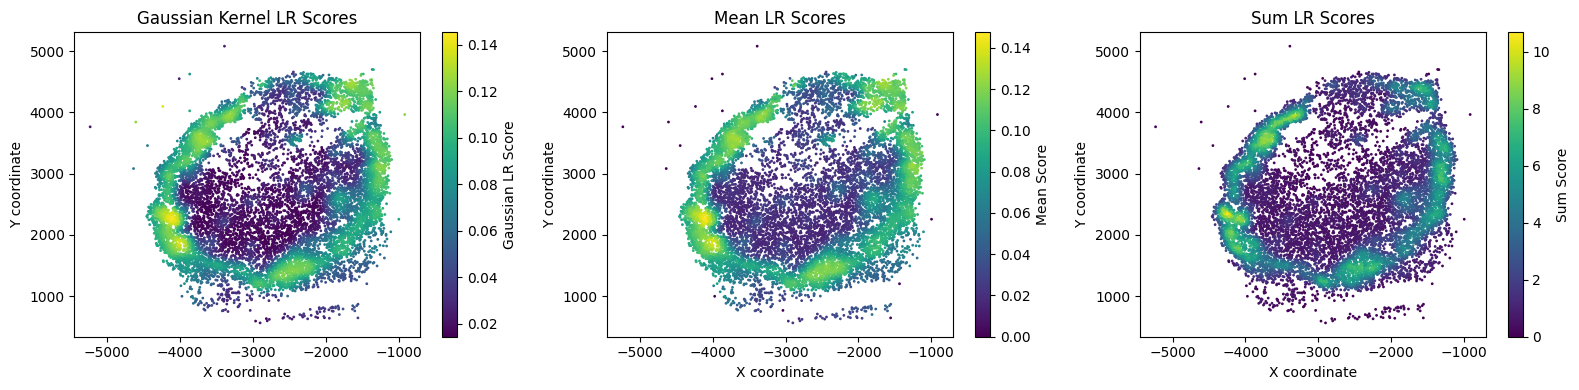

In [48]:
x = adata.obsm['spatial'][:, 0]
y = adata.obsm['spatial'][:, 1]
X = adata.to_df(layer='imputed_count')[['Pax5']].values


lr_scores = calculate_lr_scores(x, y, X, sigma_max)

# Calculate mean and sum scores
def calculate_mean_sum_scores(x, y, X, radius):
    coords = np.column_stack((x, y))
    distances = cdist(coords, coords)
    mask = distances <= radius
    
    # Exclude self-interactions
    np.fill_diagonal(mask, False)
    
    mean_scores = np.zeros_like(X)
    sum_scores = np.zeros_like(X)
    
    for i in range(len(X)):
        neighbors = X[mask[i]]
        mean_scores[i] = np.mean(neighbors, axis=0) if neighbors.size > 0 else 0
        sum_scores[i] = np.sum(neighbors, axis=0)
    
    return mean_scores, sum_scores

mean_scores, sum_scores = calculate_mean_sum_scores(x, y, X, r)

# Plotting
plt.figure(figsize=(16, 4))

# Plot 1: Gaussian kernel
plt.subplot(131)
scatter = plt.scatter(x, y, c=lr_scores[:, 0], cmap='viridis', s=1)
plt.colorbar(scatter, label='Gaussian LR Score')
plt.title('Gaussian Kernel LR Scores')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')

# Plot 2: Mean scores
plt.subplot(132)
scatter = plt.scatter(x, y, c=mean_scores[:, 0], cmap='viridis', s=1)
plt.colorbar(scatter, label='Mean Score')
plt.title('Mean LR Scores')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')

# Plot 3: Sum scores
plt.subplot(133)
scatter = plt.scatter(x, y, c=sum_scores[:, 0], cmap='viridis', s=1)
plt.colorbar(scatter, label='Sum Score')
plt.title('Sum LR Scores')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')

plt.tight_layout()
plt.show()


In [51]:
adata = sc.read_h5ad('/Users/koush/Projects/SpaceOracle/data/flowsig/adata_train_flowsig.h5ad')

In [52]:
adata

AnnData object with n_obs × n_vars = 10277 × 4998
    obs: 'cluster', 'rctd_cluster', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'spatial_kmeans'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cluster_colors', 'commot-user_database-info', 'flowsig_network', 'hvg', 'log1p', 'nsf_info', 'rctd_cluster_colors'
    obsm: 'X_flow', 'X_gem', 'X_spatial', 'commot-user_database-sum-receiver', 'commot-user_database-sum-sender', 'rctd_results', 'spatial'
    layers: 'imputed_count', 'normalized_count', 'raw_count'
    obsp: 'commot-user_database-Angptl2-Pirb', 'commot-user_database-Angptl4-Cdh5

In [100]:
adata.uns['commot-user_database-info']['df_ligrec'].query('ligand == "Ccl5"')

,ligand,receptor,pathway
12,Ccl5,Ccr5,CCL
16,Ccl5,Ackr1,CCL


In [57]:
import commot as ct

In [62]:
ct.tl.communication_direction(adata, database_name='user_database', pathway_name='App-Cd74', k=5)

<Axes: >

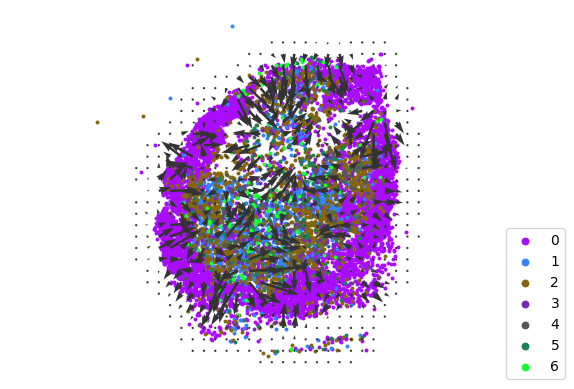

In [97]:
ct.pl.plot_cell_communication(adata, database_name='user_database', pathway_name='App-Cd74', 
                              plot_method='grid', background_legend=True,
    scale=0.00003, ndsize=8, grid_density=0.6, summary='receiver', background='cluster', 
    clustering='rctd_cluster', cmap='Alphabet',
    normalize_v = True, normalize_v_quantile=0.995)

<Axes: >

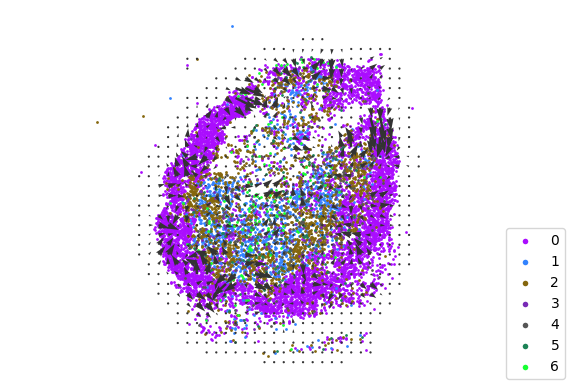

In [88]:
ct.pl.plot_cell_communication(adata, database_name='user_database', pathway_name='App-Cd74', 
                              plot_method='grid', background_legend=True,
    scale=0.00003, ndsize=4, grid_density=0.7, summary='sender', background='cluster', 
    clustering='rctd_cluster', cmap='Alphabet',
    normalize_v = True, normalize_v_quantile=0.995)

In [35]:
mean_scores

array([[0.10726569],
       [0.10072862],
       [0.09827831],
       ...,
       [0.01710277],
       [0.02920973],
       [0.10787511]])

In [36]:
lr_scores

array([[0.11511651],
       [0.10370872],
       [0.09335632],
       ...,
       [0.01597319],
       [0.03233902],
       [0.09567658]])

In [4]:
import scanpy as sc

In [74]:
adata = sc.read_10x_h5('/Users/koush/Desktop/10x/Breast_Cancer_3p_filtered_feature_bc_matrix.h5')
adata.var_names_make_unique()
sc.pp.filter_genes(adata, min_cells=1)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

/opt/homebrew/Caskroom/miniforge/base/envs/SpaceOracle/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning:

Variable names are not unique. To make them unique, call `.var_names_make_unique`.

/opt/homebrew/Caskroom/miniforge/base/envs/SpaceOracle/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning:

Variable names are not unique. To make them unique, call `.var_names_make_unique`.



In [75]:
import seaborn as sns

In [76]:
import magic

In [77]:
magic_operator = magic.MAGIC()
X_magic = magic_operator.fit_transform(adata.to_df(), genes=adata.var_names)

Calculating MAGIC...
  Running MAGIC on 5680 cells and 26156 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 4.65 seconds.
    Calculating KNN search...
    Calculated KNN search in 1.06 seconds.
    Calculating affinities...
    Calculated affinities in 0.94 seconds.
  Calculated graph and diffusion operator in 6.74 seconds.
  Running MAGIC with `solver='exact'` on 26156-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
  Calculating imputation...
  Calculated imputation in 11.83 seconds.
Calculated MAGIC in 28.66 seconds.


In [79]:
adata

AnnData object with n_obs × n_vars = 5680 × 26156
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'log1p'

In [89]:
'TBX21' in adata.var_names

True

In [80]:
import numpy as np

<Axes: xlabel='CD4', ylabel='TBX21'>

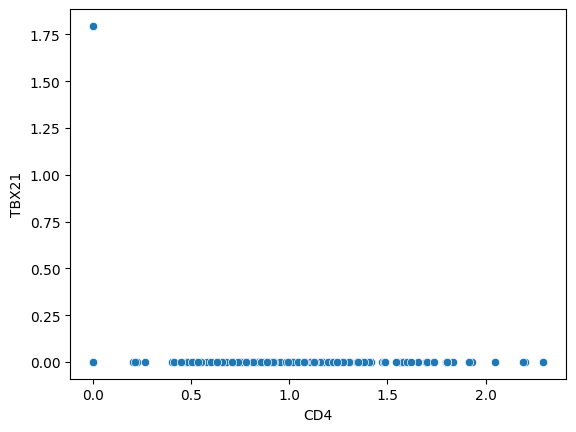

In [90]:
sns.scatterplot(data=adata.to_df(), x='CD4', y='TBX21')


In [111]:
adata = sc.read_h5ad('/tmp/adata.h5ad')
adata2 = sc.read_h5ad('/tmp/adata2.h5ad')

/opt/homebrew/Caskroom/miniforge/base/envs/SpaceOracle/lib/python3.9/site-packages/anndata/compat/__init__.py:311: FutureWarning:

Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.



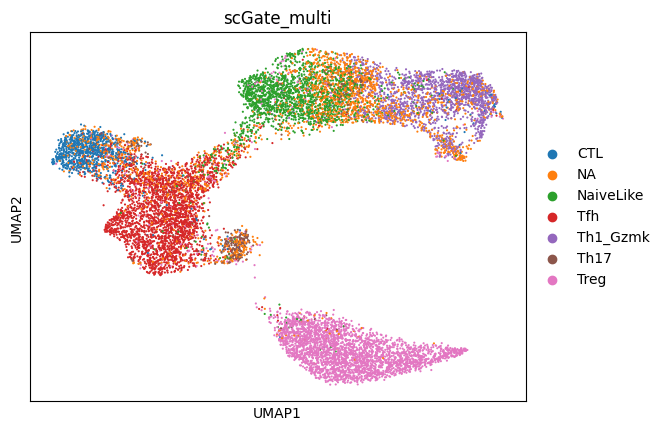

In [114]:
sc.pl.umap(adata, color='scGate_multi')

In [129]:
adata3 = sc.read_mtx('/Users/koush/Downloads/GSE122675_matrix.mtx')

In [136]:
adata3.to_df()

,0,1,2,3,4,5,6,7,8,9,...,11795,11796,11797,11798,11799,11800,11801,11802,11803,11804
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27993,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27994,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27995,1.0,0.0,0.0,0.0,2.0,1.0,2.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0
27996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [144]:
barcodes =pd.read_csv('/Users/koush/Downloads/GSE122675_barcodes.tsv.gz', header=None)[0].values

In [141]:
genes = pd.read_csv('/Users/koush/Downloads/GSE122675_genes.tsv', sep='\t', header=None)[1].values

In [163]:
len(barcodes), len(genes), adata3.shape

(11805, 27998, (27998, 11805))

In [172]:
adatax = anndata.AnnData(pd.DataFrame(adata3.X.toarray().T, columns=genes, index=barcodes))
adatax.var_names_make_unique()

/opt/homebrew/Caskroom/miniforge/base/envs/SpaceOracle/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning:

Variable names are not unique. To make them unique, call `.var_names_make_unique`.



In [173]:
# Filter cells with a minimum number of genes expressed
sc.pp.filter_cells(adatax, min_genes=200)

# Filter genes that are expressed in a minimum number of cells
sc.pp.filter_genes(adatax, min_cells=3)

# Normalize the data
sc.pp.normalize_total(adatax, target_sum=1e4)

# Logarithmize the data
sc.pp.log1p(adatax)

# Identify highly variable genes
sc.pp.highly_variable_genes(adatax, min_mean=0.0125, max_mean=3, min_disp=0.5)

# Keep only highly variable genes
adatax = adatax[:, adatax.var.highly_variable]

# Perform PCA
sc.tl.pca(adatax, svd_solver='arpack')

# Compute the neighborhood graph
sc.pp.neighbors(adatax, n_neighbors=10, n_pcs=40)

# Perform UMAP
sc.tl.umap(adatax)



/opt/homebrew/Caskroom/miniforge/base/envs/SpaceOracle/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning:

Setting element `.obsm['X_pca']` of view, initializing view as actual.



In [174]:
sc.tl.leiden(adatax)

/var/folders/jr/19l2mwvs76v4rv5vy8j4vrch0000gn/T/ipykernel_14366/3909301490.py:1: FutureWarning:

In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.



In [182]:
adatax.to_df()

,Fam178b,Il1r2,Nabp1,Stk17b,Ankrd44,Cd28,Ctla4,Icos,Ikzf2,Slc11a1,...,Uhrf2,Gldc,Ifit3,Ifit1bl1,Ifit1,Hhex,Pdlim1,Dusp5,Pdcd4,mt-Nd2
AAACCTGCAGAGCCAA-1,0.0,0.000000,0.000000,0.845246,0.000000,0.845246,1.296671,0.00000,0.000000,0.0,...,1.296671,0.845246,0.845246,0.0,0.0,0.0,0.00000,0.000000,0.000000,2.659245
AAACCTGTCCAGGGCT-1,0.0,0.846157,0.846157,1.297830,0.000000,0.846157,0.846157,0.00000,0.000000,0.0,...,0.846157,0.000000,0.000000,0.0,0.0,0.0,1.29783,0.846157,0.000000,1.607840
AAACCTGTCCTTAATC-1,0.0,0.000000,0.000000,0.000000,0.000000,1.371040,1.371040,0.00000,1.371040,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.37104,0.000000,0.000000,1.371040
AAACCTGTCGAGAGCA-1,0.0,0.000000,0.000000,1.201807,0.000000,0.000000,1.732053,0.00000,1.201807,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.000000,2.332580
AAACGGGCACCACGTG-1,0.0,0.492088,0.492088,1.067185,1.067185,0.000000,0.000000,0.00000,0.820421,0.0,...,1.067185,0.492088,0.000000,0.0,0.0,0.0,0.00000,0.492088,0.000000,1.571605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTAGAAGCCCA-4,0.0,0.000000,0.000000,0.000000,0.000000,1.341939,0.000000,0.00000,2.510072,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.000000,2.888077
TTTGTCAAGGACTGGT-4,0.0,0.000000,0.000000,0.926552,0.926552,0.000000,1.718715,0.00000,0.000000,0.0,...,0.000000,0.926552,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.000000,2.457921
TTTGTCAGTAATTGGA-4,0.0,1.514638,1.213483,0.780513,0.000000,1.514638,1.933398,0.00000,0.000000,0.0,...,0.780513,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.780513,0.780513
TTTGTCAGTCGTGGCT-4,0.0,0.000000,0.000000,1.081703,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,...,0.000000,1.081703,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.000000,1.589112


In [ ]:
sc.tl.umap(adatax, min_dist=0.5)

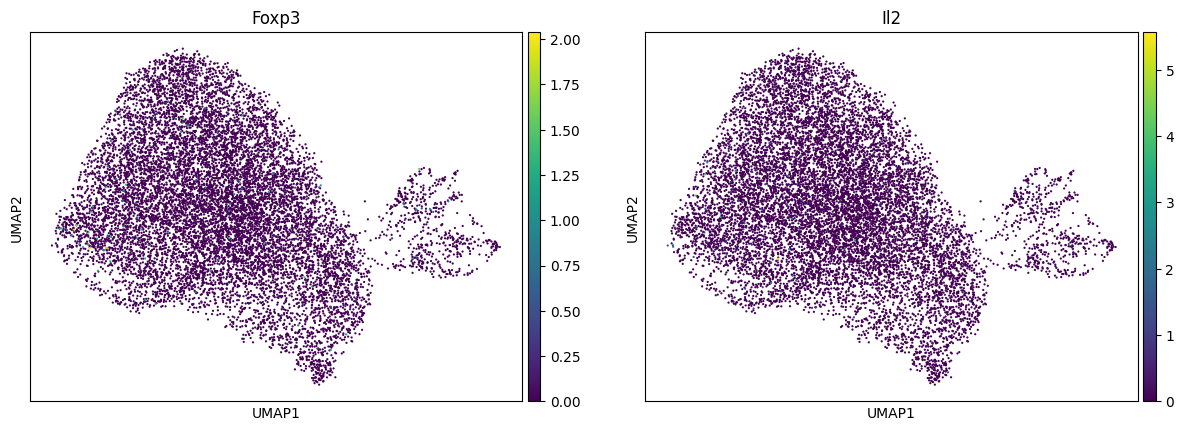

: 

In [190]:
sc.pl.umap(adatax, color=['Foxp3', 'Il2'])